In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import re

from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:

carsMaster = pd.read_csv("Car names and make.csv",header=None)
carsMaster.columns=["fullNames"]
carsMaster.head()

,fullNames
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [3]:
# lets review the name lengths
carsMaster["wCounts"] = carsMaster["fullNames"].apply(lambda x: len(x.split()))
carsMaster.wCounts.value_counts()

4    132
5     44
6     14
7      6
Name: wCounts, dtype: int64

In [4]:
# lets review the 7 word long names
print(carsMaster.loc[carsMaster.wCounts==7,["fullNames"]].values)

[['Chevrolet Silverado 1500 Hybrid Crew Cab 2012']
 ['Chevrolet Corvette Ron Fellows Edition Z06 2007']
 ['Chevrolet Silverado 1500 Classic Extended Cab 2007']
 ['Dodge Ram Pickup 3500 Crew Cab 2010']
 ['Dodge Ram Pickup 3500 Quad Cab 2009']
 ['Ford F-450 Super Duty Crew Cab 2012']]


In [5]:
# before we process any information from the fullNames, lets remove any path separator '/' in the class names
carsMaster["fullNames"] = carsMaster["fullNames"].apply(lambda x: '-'.join(x.split('/')))

In [6]:
# lets first separate the OEM name & Year-of-Make data and review again
carsMaster["OEM"] = carsMaster["fullNames"].apply(lambda x: x.split()[0])
carsMaster["YEAR"] = carsMaster["fullNames"].apply(lambda x: x.split()[-1])

# also pickup the second word to verify if it was part of OEM name or Model name
carsMaster["chk"] = carsMaster["fullNames"].apply(lambda x: x.split()[1])
carsMaster.head()

,fullNames,wCounts,OEM,YEAR,chk
0,AM General Hummer SUV 2000,5,AM,2000,General
1,Acura RL Sedan 2012,4,Acura,2012,RL
2,Acura TL Sedan 2012,4,Acura,2012,TL
3,Acura TL Type-S 2008,4,Acura,2008,TL
4,Acura TSX Sedan 2012,4,Acura,2012,TSX


In [7]:
# lets review on basis of OEM
dtmp = carsMaster.groupby(by="OEM")["chk"].unique()
dtmp

OEM
AM                                                       [General]
Acura                                  [RL, TL, TSX, Integra, ZDX]
Aston                                                     [Martin]
Audi                    [RS, A5, TTS, R8, V8, 100, TT, S6, S5, S4]
BMW              [ActiveHybrid, 1, 3, 6, X5, X6, M3, M5, M6, X3...
Bentley                            [Continental, Arnage, Mulsanne]
Bugatti                                                   [Veyron]
Buick                            [Regal, Rainier, Verano, Enclave]
Cadillac                                    [CTS-V, SRX, Escalade]
Chevrolet        [Silverado, Corvette, Traverse, Camaro, HHR, I...
Chrysler                [Aspen, Sebring, Town, 300, Crossfire, PT]
Daewoo                                                    [Nubira]
Dodge            [Caliber, Caravan, Ram, Sprinter, Journey, Dak...
Eagle                                                      [Talon]
FIAT                                                      

In [8]:
# the suspects for 2 word OEM names are whereever there are only 1 uniques against the extracted first name of the OE
# lets try to short list those and review better
carsMaster.loc[carsMaster.OEM.isin(dtmp.loc[carsMaster.groupby(by="OEM")["chk"].nunique()==1].index)]

,fullNames,wCounts,OEM,YEAR,chk
0,AM General Hummer SUV 2000,5,AM,2000,General
7,Aston Martin V8 Vantage Convertible 2012,6,Aston,2012,Martin
8,Aston Martin V8 Vantage Coupe 2012,6,Aston,2012,Martin
9,Aston Martin Virage Convertible 2012,5,Aston,2012,Martin
10,Aston Martin Virage Coupe 2012,5,Aston,2012,Martin
44,Bugatti Veyron 16.4 Convertible 2009,5,Bugatti,2009,Veyron
45,Bugatti Veyron 16.4 Coupe 2009,5,Bugatti,2009,Veyron
81,Daewoo Nubira Wagon 2002,4,Daewoo,2002,Nubira
97,Eagle Talon Hatchback 1998,4,Eagle,1998,Talon
98,FIAT 500 Abarth 2012,4,FIAT,2012,500


In [9]:
# manually listing the OEM names with 2 words based on above table
twinWordOE = ['AM', 'Aston', 'Land']
twinWordOE

['AM', 'Aston', 'Land']

In [10]:
# lets update the OEM  names accordingly
dtmp = carsMaster.loc[carsMaster.OEM.isin(twinWordOE)]
carsMaster.loc[carsMaster.OEM.isin(twinWordOE),["OEM"]] = dtmp.fullNames.apply(lambda x: x.split()[:2])
carsMaster.loc[dtmp.index]

,fullNames,wCounts,OEM,YEAR,chk
0,AM General Hummer SUV 2000,5,"[AM, General]",2000,General
7,Aston Martin V8 Vantage Convertible 2012,6,"[Aston, Martin]",2012,Martin
8,Aston Martin V8 Vantage Coupe 2012,6,"[Aston, Martin]",2012,Martin
9,Aston Martin Virage Convertible 2012,5,"[Aston, Martin]",2012,Martin
10,Aston Martin Virage Coupe 2012,5,"[Aston, Martin]",2012,Martin
153,Land Rover Range Rover SUV 2012,6,"[Land, Rover]",2012,Rover
154,Land Rover LR2 SUV 2012,5,"[Land, Rover]",2012,Rover


In [11]:
# lets us now extract the model name
[w for w in carsMaster.fullNames[10].split() if w not in carsMaster.OEM[10] and w != str(carsMaster.YEAR[10])]

['Virage', 'Coupe']

In [12]:
carsMaster["MODEL"] = carsMaster.apply(lambda row: [w for w in row["fullNames"].split() if w not in row["OEM"] and w!=str(row["YEAR"])],axis=1)
display(carsMaster.loc[dtmp.index])
display(carsMaster.sample(5))

,fullNames,wCounts,OEM,YEAR,chk,MODEL
0,AM General Hummer SUV 2000,5,"[AM, General]",2000,General,"[Hummer, SUV]"
7,Aston Martin V8 Vantage Convertible 2012,6,"[Aston, Martin]",2012,Martin,"[V8, Vantage, Convertible]"
8,Aston Martin V8 Vantage Coupe 2012,6,"[Aston, Martin]",2012,Martin,"[V8, Vantage, Coupe]"
9,Aston Martin Virage Convertible 2012,5,"[Aston, Martin]",2012,Martin,"[Virage, Convertible]"
10,Aston Martin Virage Coupe 2012,5,"[Aston, Martin]",2012,Martin,"[Virage, Coupe]"
153,Land Rover Range Rover SUV 2012,6,"[Land, Rover]",2012,Rover,"[Range, SUV]"
154,Land Rover LR2 SUV 2012,5,"[Land, Rover]",2012,Rover,"[LR2, SUV]"


,fullNames,wCounts,OEM,YEAR,chk,MODEL
149,Lamborghini Reventon Coupe 2008,4,Lamborghini,2008,Reventon,"[Reventon, Coupe]"
79,Chrysler Crossfire Convertible 2008,4,Chrysler,2008,Crossfire,"[Crossfire, Convertible]"
42,Bentley Continental GT Coupe 2007,5,Bentley,2007,Continental,"[Continental, GT, Coupe]"
104,Fisker Karma Sedan 2012,4,Fisker,2012,Karma,"[Karma, Sedan]"
46,Buick Regal GS 2012,4,Buick,2012,Regal,"[Regal, GS]"


In [13]:
# lets properly combine the OEM names & Model Names without lists
carsMaster["OEM"] = carsMaster["OEM"].apply(lambda x: x if type(x)==str else '_'.join(x))
carsMaster["MODEL"] = carsMaster["MODEL"].apply(lambda x: x if type(x)==str else '_'.join(x))
display(carsMaster.loc[dtmp.index])
display(carsMaster.sample(5))

,fullNames,wCounts,OEM,YEAR,chk,MODEL
0,AM General Hummer SUV 2000,5,AM_General,2000,General,Hummer_SUV
7,Aston Martin V8 Vantage Convertible 2012,6,Aston_Martin,2012,Martin,V8_Vantage_Convertible
8,Aston Martin V8 Vantage Coupe 2012,6,Aston_Martin,2012,Martin,V8_Vantage_Coupe
9,Aston Martin Virage Convertible 2012,5,Aston_Martin,2012,Martin,Virage_Convertible
10,Aston Martin Virage Coupe 2012,5,Aston_Martin,2012,Martin,Virage_Coupe
153,Land Rover Range Rover SUV 2012,6,Land_Rover,2012,Rover,Range_SUV
154,Land Rover LR2 SUV 2012,5,Land_Rover,2012,Rover,LR2_SUV


,fullNames,wCounts,OEM,YEAR,chk,MODEL
62,Chevrolet Sonic Sedan 2012,4,Chevrolet,2012,Sonic,Sonic_Sedan
34,BMW M5 Sedan 2010,4,BMW,2010,M5,M5_Sedan
147,Jeep Grand Cherokee SUV 2012,5,Jeep,2012,Grand,Grand_Cherokee_SUV
96,Dodge Charger SRT-8 2009,4,Dodge,2009,Charger,Charger_SRT-8
12,Audi A5 Coupe 2012,4,Audi,2012,A5,A5_Coupe


In [14]:
# lets drop & rearrange the master data
carsMaster = carsMaster[["fullNames","OEM","MODEL","YEAR"]]
carsMaster.head()

,fullNames,OEM,MODEL,YEAR
0,AM General Hummer SUV 2000,AM_General,Hummer_SUV,2000
1,Acura RL Sedan 2012,Acura,RL_Sedan,2012
2,Acura TL Sedan 2012,Acura,TL_Sedan,2012
3,Acura TL Type-S 2008,Acura,TL_Type-S,2008
4,Acura TSX Sedan 2012,Acura,TSX_Sedan,2012


In [15]:
# total number of classes to predict
carsMaster.OEM.nunique()+carsMaster.MODEL.nunique()+carsMaster.YEAR.nunique()

254

Lets read the image data files in to our notebook

In [16]:
BASEfldr = 'Car Images/'
TRAINfldr = 'Train Images/'
TESTfldr = 'Test Images/'

In [17]:
# lets take a record of data about the training imagess
path = BASEfldr+TRAINfldr
iCols = ["Image","ImagePath","folderName","height","width"]
imageMasterTrain = pd.DataFrame(columns=iCols)
imPath = np.empty(0)
fldrName = np.empty(0)
imageName = np.empty(0)
imH = np.empty(0)
imW = np.empty(0)
for cls in tqdm(carsMaster.fullNames,desc="imScanTrain"):
    try:
        os.listdir(path+cls)
    except:
        print("path error: ",path+cls)
        continue
    for img in os.listdir(path+cls):
        imPath = np.append(imPath,np.array([path+cls+'/'+img]))
        fldrName = np.append(fldrName,np.array([cls]))
        imageName = np.append(imageName,np.array([img]))
        (h,w) = Image.open(path+cls+'/'+img).size
        imH = np.append(imH,np.array([h]))
        imW = np.append(imW,np.array([w]))
imageMasterTrain["Image"] = imageName
imageMasterTrain["ImagePath"] = imPath
imageMasterTrain["folderName"] = fldrName
imageMasterTrain["height"] = imH
imageMasterTrain["width"] = imW

imScanTrain: 100%|██████████| 196/196 [00:05<00:00, 34.71it/s]


In [18]:
# lets take a record of data about the testing imagess
path = BASEfldr+TESTfldr
iCols = ["Image","ImagePath","folderName","height","width"]
imageMasterTest = pd.DataFrame(columns=iCols)
imPath = np.empty(0)
fldrName = np.empty(0)
imageName = np.empty(0)
imH = np.empty(0)
imW = np.empty(0)
for cls in tqdm(carsMaster.fullNames,desc="imScanTest"):
    try:
        os.listdir(path+cls)
    except:
        print("path error: ",cls)
        continue
    for img in os.listdir(path+cls):
        imPath = np.append(imPath,np.array([path+cls+'/'+img]))
        fldrName = np.append(fldrName,np.array([cls]))
        imageName = np.append(imageName,np.array([img]))
        (h,w) = Image.open(path+cls+'/'+img).size
        imH = np.append(imH,np.array([h]))
        imW = np.append(imW,np.array([w]))
imageMasterTest["Image"] = imageName
imageMasterTest["ImagePath"] = imPath
imageMasterTest["folderName"] = fldrName
imageMasterTest["height"] = imH
imageMasterTest["width"] = imW

imScanTest: 100%|██████████| 196/196 [00:05<00:00, 36.28it/s]


In [19]:
imageMasterTrain["pixels"] = imageMasterTrain.height * imageMasterTrain.width
imageMasterTest["pixels"] = imageMasterTest.height * imageMasterTest.width

In [20]:
imageMasterTrain.head()

,Image,ImagePath,folderName,height,width,pixels
0,04544.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,339.0,200.0,67800.0
1,00163.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,700.0,525.0,367500.0
2,00462.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,85.0,64.0,5440.0
3,00522.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,94.0,71.0,6674.0
4,00707.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,700.0,439.0,307300.0


In [21]:
imageMasterTest.head()

,Image,ImagePath,folderName,height,width,pixels
0,03246.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,101.0,41.0,4141.0
1,00076.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,96.0,64.0,6144.0
2,00457.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,250.0,144.0,36000.0
3,00684.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,373.0,216.0,80568.0
4,01117.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,800.0,600.0,480000.0


In [22]:
print("largest image:"),display(imageMasterTrain.loc[imageMasterTrain.pixels.argmax()].to_frame().T)
print("tallest image:"),display(imageMasterTrain.loc[imageMasterTrain.height.argmax()].to_frame().T)
print("widest image:"),display(imageMasterTrain.loc[imageMasterTrain.width.argmax()].to_frame().T)
print("\n")
print("smallest image:"),display(imageMasterTrain.loc[imageMasterTrain.pixels.argmin()].to_frame().T)
print("shortest image:"),display(imageMasterTrain.loc[imageMasterTrain.height.argmin()].to_frame().T)
print("leanest image:"),display(imageMasterTrain.loc[imageMasterTrain.width.argmin()].to_frame().T)

largest image:


,Image,ImagePath,folderName,height,width,pixels
2573,05945.jpg,Car Images/Train Images/Chevrolet Sonic Sedan ...,Chevrolet Sonic Sedan 2012,5616.0,3744.0,21026304.0


tallest image:


,Image,ImagePath,folderName,height,width,pixels
2573,05945.jpg,Car Images/Train Images/Chevrolet Sonic Sedan ...,Chevrolet Sonic Sedan 2012,5616.0,3744.0,21026304.0


widest image:


,Image,ImagePath,folderName,height,width,pixels
2573,05945.jpg,Car Images/Train Images/Chevrolet Sonic Sedan ...,Chevrolet Sonic Sedan 2012,5616.0,3744.0,21026304.0




smallest image:


,Image,ImagePath,folderName,height,width,pixels
2294,00097.jpg,Car Images/Train Images/Chevrolet Corvette Ron...,Chevrolet Corvette Ron Fellows Edition Z06 2007,78.0,58.0,4524.0


shortest image:


,Image,ImagePath,folderName,height,width,pixels
2294,00097.jpg,Car Images/Train Images/Chevrolet Corvette Ron...,Chevrolet Corvette Ron Fellows Edition Z06 2007,78.0,58.0,4524.0


leanest image:


,Image,ImagePath,folderName,height,width,pixels
5107,04047.jpg,Car Images/Train Images/Geo Metro Convertible ...,Geo Metro Convertible 1993,101.0,57.0,5757.0


(None, None)

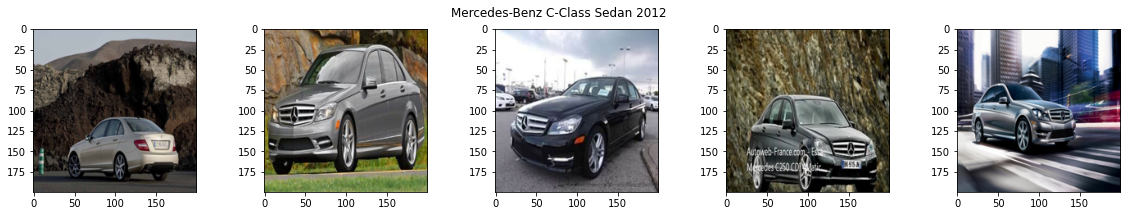

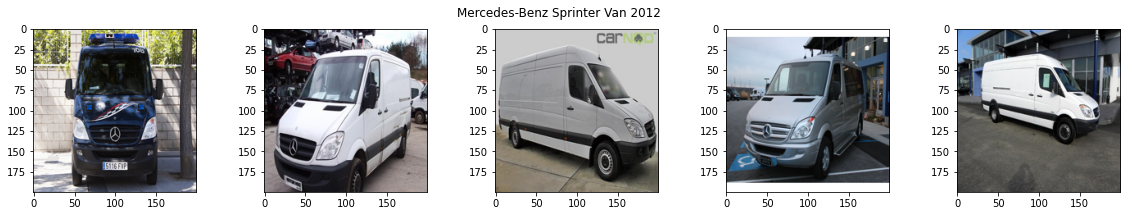

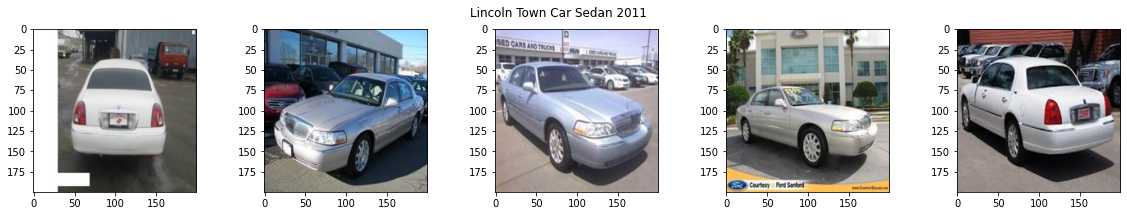

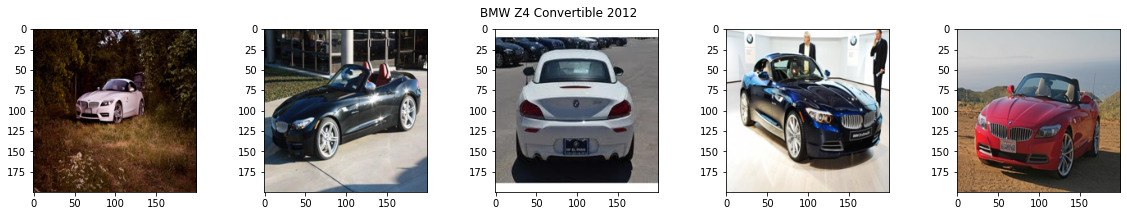

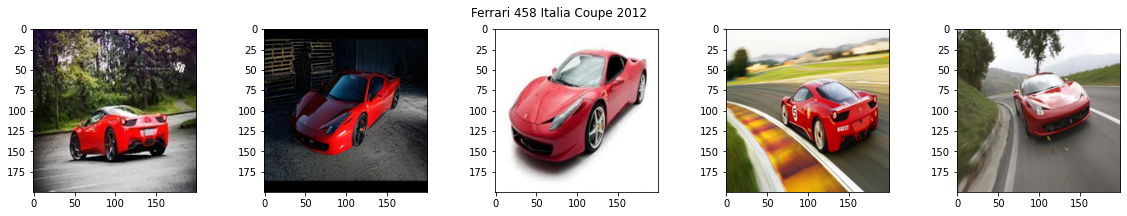

In [23]:
# display 5 random images of 5 random classes
classes = np.random.choice(imageMasterTrain.folderName.unique(),5,replace=False)
for cls in classes:
    dtmp = imageMasterTrain.loc[imageMasterTrain.folderName == cls]
    images = np.random.choice(dtmp.ImagePath.values,5,replace=False)
    plt.figure(figsize=(20,3))
    plt.suptitle(cls)
    for i,img in enumerate(images):
        img = Image.open(img).resize((200,200))
        plt.subplot(1,5,i+1)
        plt.imshow(img)
    plt.show()

In [24]:
# let us read the annotations datafile to pandas dataframe
trainAnnot = pd.read_csv('./Annotations/Train Annotations.csv')
testAnnot = pd.read_csv('./Annotations/Test Annotation.csv')
Acols = ['Image Name', 'x1', 'y1', 'x2','y2', 'Image class']
trainAnnot.columns = Acols
testAnnot.columns = Acols

In [25]:
trainAnnot.head()

,Image Name,x1,y1,x2,y2,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [26]:
imageMasterTrain.head()

,Image,ImagePath,folderName,height,width,pixels
0,04544.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,339.0,200.0,67800.0
1,00163.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,700.0,525.0,367500.0
2,00462.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,85.0,64.0,5440.0
3,00522.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,94.0,71.0,6674.0
4,00707.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,700.0,439.0,307300.0


In [27]:
trainDF = pd.merge(imageMasterTrain,trainAnnot,how='outer',left_on='Image',right_on='Image Name')
testDF = pd.merge(imageMasterTest,testAnnot,how='outer',left_on='Image',right_on='Image Name')

display(trainDF.head(),testDF.head())

,Image,ImagePath,folderName,height,width,pixels,Image Name,x1,y1,x2,y2,Image class
0,04544.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,339.0,200.0,67800.0,04544.jpg,18,18,328,190,1
1,00163.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,700.0,525.0,367500.0,00163.jpg,46,84,661,428,1
2,00462.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,85.0,64.0,5440.0,00462.jpg,5,8,83,58,1
3,00522.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,94.0,71.0,6674.0,00522.jpg,6,7,94,68,1
4,00707.jpg,Car Images/Train Images/AM General Hummer SUV ...,AM General Hummer SUV 2000,700.0,439.0,307300.0,00707.jpg,26,32,677,418,1


,Image,ImagePath,folderName,height,width,pixels,Image Name,x1,y1,x2,y2,Image class
0,03246.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,101.0,41.0,4141.0,03246.jpg,9,3,93,41,1
1,00076.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,96.0,64.0,6144.0,00076.jpg,11,13,84,60,1
2,00457.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,250.0,144.0,36000.0,00457.jpg,31,20,226,119,1
3,00684.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,373.0,216.0,80568.0,00684.jpg,111,54,365,190,1
4,01117.jpg,Car Images/Test Images/AM General Hummer SUV 2...,AM General Hummer SUV 2000,800.0,600.0,480000.0,01117.jpg,45,39,729,414,1


In [28]:
carsMaster.head()

,fullNames,OEM,MODEL,YEAR
0,AM General Hummer SUV 2000,AM_General,Hummer_SUV,2000
1,Acura RL Sedan 2012,Acura,RL_Sedan,2012
2,Acura TL Sedan 2012,Acura,TL_Sedan,2012
3,Acura TL Type-S 2008,Acura,TL_Type-S,2008
4,Acura TSX Sedan 2012,Acura,TSX_Sedan,2012


In [29]:
# lets merge the OEM, MODEL & YEAR data
trainDF = pd.merge(trainDF,carsMaster,how='outer',left_on='folderName',right_on='fullNames')
testDF = pd.merge(testDF,carsMaster,how='outer',left_on='folderName',right_on='fullNames')

In [30]:
# update class index to start from ZERO
trainDF["Image class"] = trainDF["Image class"]-1
testDF["Image class"] = testDF["Image class"]-1

In [31]:
# merge cars_names_and_make csv data with the annotation class name field
trainDF = pd.merge(trainDF,carsMaster,how='outer',left_on='Image class',right_index=True)
testDF = pd.merge(testDF,carsMaster,how='outer',left_on='Image class',right_index=True)

In [32]:
# review if any mismatches available
display(trainDF.loc[trainDF.folderName!=trainDF.fullNames_x])
display(trainDF.loc[trainDF.folderName!=trainDF.fullNames_y])
display(trainDF.loc[trainDF.fullNames_x!=trainDF.fullNames_y])
display(testDF.loc[testDF.folderName!=testDF.fullNames_x])
display(testDF.loc[testDF.folderName!=testDF.fullNames_y])
display(testDF.loc[testDF.fullNames_x!=testDF.fullNames_y])

,Image,ImagePath,folderName,height,width,pixels,Image Name,x1,y1,x2,y2,Image class,fullNames_x,OEM_x,MODEL_x,YEAR_x,fullNames_y,OEM_y,MODEL_y,YEAR_y


,Image,ImagePath,folderName,height,width,pixels,Image Name,x1,y1,x2,y2,Image class,fullNames_x,OEM_x,MODEL_x,YEAR_x,fullNames_y,OEM_y,MODEL_y,YEAR_y


,Image,ImagePath,folderName,height,width,pixels,Image Name,x1,y1,x2,y2,Image class,fullNames_x,OEM_x,MODEL_x,YEAR_x,fullNames_y,OEM_y,MODEL_y,YEAR_y


,Image,ImagePath,folderName,height,width,pixels,Image Name,x1,y1,x2,y2,Image class,fullNames_x,OEM_x,MODEL_x,YEAR_x,fullNames_y,OEM_y,MODEL_y,YEAR_y


,Image,ImagePath,folderName,height,width,pixels,Image Name,x1,y1,x2,y2,Image class,fullNames_x,OEM_x,MODEL_x,YEAR_x,fullNames_y,OEM_y,MODEL_y,YEAR_y


,Image,ImagePath,folderName,height,width,pixels,Image Name,x1,y1,x2,y2,Image class,fullNames_x,OEM_x,MODEL_x,YEAR_x,fullNames_y,OEM_y,MODEL_y,YEAR_y


having cross merged and synced with "Train/Test Annotations.csv", "Car names and make.csv" and the images in the "Train/Test images folders",<br>
it is found to have no mismatch of information. lets us try now remove unwanted columns and make the dataframe more readable

In [33]:
# finalize the images dataframe
trainDF = trainDF[["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","OEM_x","MODEL_x","YEAR_x",]]
testDF = testDF[["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","OEM_x","MODEL_x","YEAR_x",]]

trainDF.columns = ["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","OEM","MODEL","YEAR"]
testDF.columns = ["Image","ImagePath",'x1','y1','x2','y2','height','width',"folderName","OEM","MODEL","YEAR"]

trainDF["TARGETS"] = trainDF.apply(lambda row: [row["OEM"],row["MODEL"],row["YEAR"]],axis=1).values.copy()
testDF["TARGETS"] = testDF.apply(lambda row: [row["OEM"],row["MODEL"],row["YEAR"]],axis=1).values.copy()

In [34]:
# lets us now create an ImageDataGenerator for using with the Neural Network solver
TrainDatagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
                                shear_range = 0.2, zoom_range = 0.2,
                                width_shift_range = 0.1, height_shift_range = 0.1,
                                horizontal_flip = True, vertical_flip = False,
                                data_format = 'channels_last', validation_split = 0.1)
TestDatagen = ImageDataGenerator(rescale = 1./255)

In [35]:
# create training, validation & testing datasets using the ImageDataGenerators
trainset = TrainDatagen.flow_from_dataframe(trainDF,x_col="ImagePath",y_col="TARGETS",
                                            target_size = (50,50),batch_size=32, subset='training',class_mode = 'categorical')
validationset = TrainDatagen.flow_from_dataframe(trainDF,x_col="ImagePath",y_col="TARGETS",
                                                    target_size = (50,50),batch_size=32, subset='validation',class_mode = 'categorical')
testset = TestDatagen.flow_from_dataframe(testDF,x_col="ImagePath",y_col="TARGETS",
                                            target_size = (50,50),batch_size=32, class_mode = 'categorical')

Found 7330 validated image filenames belonging to 254 classes.
Found 814 validated image filenames belonging to 254 classes.
Found 8041 validated image filenames belonging to 254 classes.
